<a href="https://colab.research.google.com/github/cfreeman22/D213/blob/main/D213_task1_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D213 Advanced Data Analytics Task 1 Time Series Analysis

 

In [1]:

! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.6 MB/s eta 0:00:00


In [2]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [3]:
#reading the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Reading the data from my google drive.
data = pd.read_csv('/content/drive/My Drive/teleco_time_series .csv')

## __Data Preparation steps__

In [5]:
data.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [6]:
#checking for nulls
data.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [7]:
# Setting the Day column as the index for easier processing
# Since there is no starting date mentioned, let us assume the first date of operation was Jan 1st, 2017
data.set_index('Day',inplace=True)
data.index=pd.to_datetime(data.index, unit = 'D', origin = '2017-01-01')

## __C1 Line graph visualization of the time series__

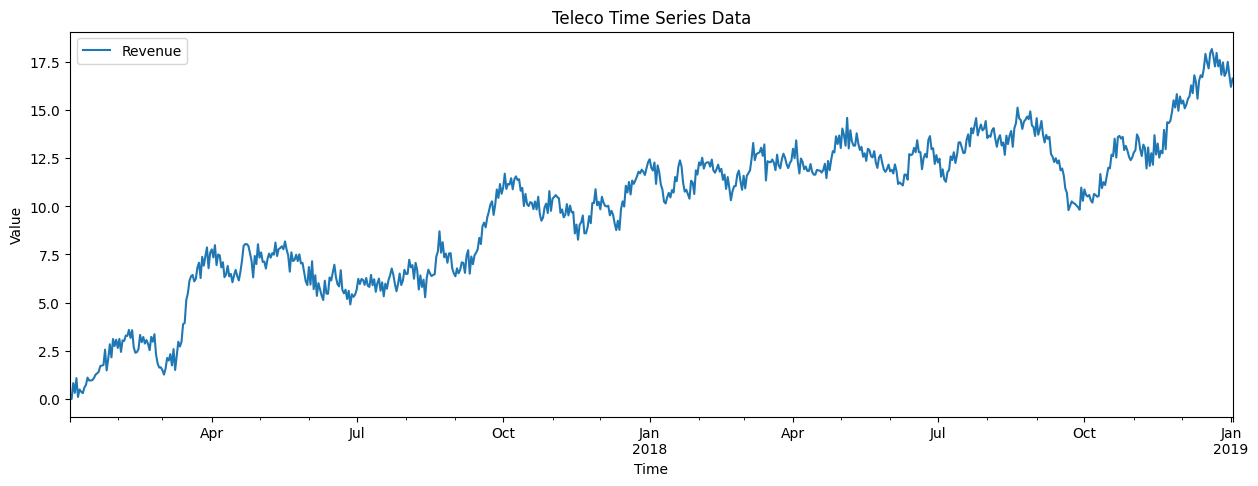

In [8]:
# Plotting the time series
data.plot(figsize=(15, 5))
plt.title("Teleco Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

The frequency is complete, which means there are no gaps in the data, and it is all equally spaced. The data presented no null values, and the length ranged from 0 to 730, with 731 rows and two columns. The first column, "Day," is set as the index to be more easily processed as a time series. The index is converted to a panda's datetime with a starting date of Jan 1st, 2017, assuming that this was the telecommunication company's first operation date.

## __C3 Evaluate the Stationarity of the Time Series__

To evaluate the stationarity of a time series, we can use various statistical tests such as the Augmented Dickey-Fuller (ADF) test or the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. These tests check if the mean and variance of the time series are constant over time. The output below displays the ADF test statistic, p-value, and critical values at different confidence levels. If the p-value is less than a specified significance level (e.g., 0.05), we can reject the null hypothesis that the time series is non-stationary. Our crucial values for stationarity are -3.4, -2.8, and -2.5, respectively, and our test statistic is -1.9. We can see from this result that our data is not stationary because the test statistic is not below the crucial values.

In [9]:
# Define the ADF test function
def adf_test(timeseries):
    adf_result = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','# Lags Used','# Observations Used'])
    for key,value in adf_result[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print(adf_output)

# Apply the ADF test to the data
adf_test(data['Revenue'])

Test Statistic           -1.924612
p-value                   0.320573
# Lags Used               1.000000
# Observations Used     729.000000
Critical Value (1%)      -3.439352
Critical Value (5%)      -2.865513
Critical Value (10%)     -2.568886
dtype: float64


## __C.4 Steps used to prepare the data for analysis__
- Adjusting the statonarity of the data
- Checking for nulls, duplicates
- Make a Clean copy
 

In [10]:
#Making time series stationary
data_diff = data.diff().dropna()
data_diff

,Revenue
Day,
2017-01-03,0.000793
2017-01-04,0.824749
2017-01-05,-0.505210
2017-01-06,0.762222
2017-01-07,-0.974900
...,...
2018-12-29,0.170280
2018-12-30,0.559108
2018-12-31,-0.687028


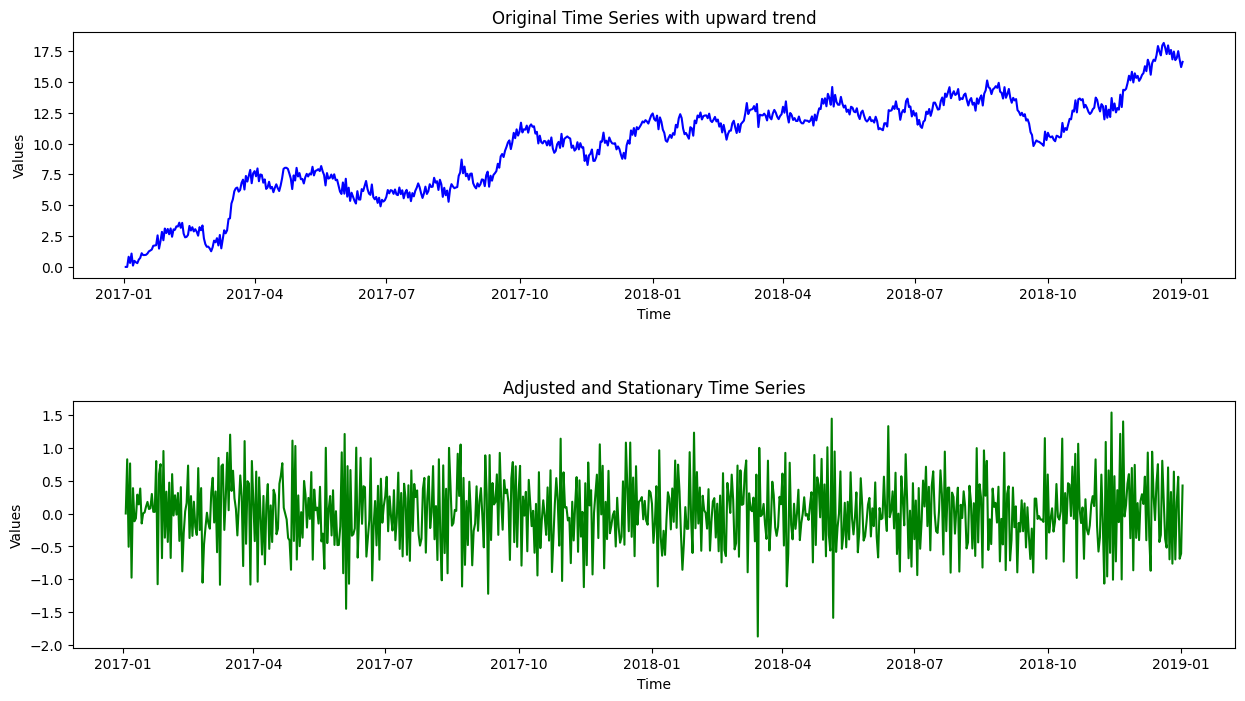

In [11]:
# Create a figure with two subplots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8)) 
# Add data and labels to the first subplot 
ax1.plot(data["Revenue"], color='blue') 
ax1.set_title('Original Time Series with upward trend') 
ax1.set_xlabel('Time') 
ax1.set_ylabel('Values') 
# Add data and labels to the second subplot 
ax2.plot(data_diff['Revenue'], color='green') 
ax2.set_title('Adjusted and Stationary Time Series') 
ax2.set_xlabel('Time') 
ax2.set_ylabel('Values') 
# Add spacing between subplots and display the figure 
plt.subplots_adjust(hspace=0.5) 
plt.show()

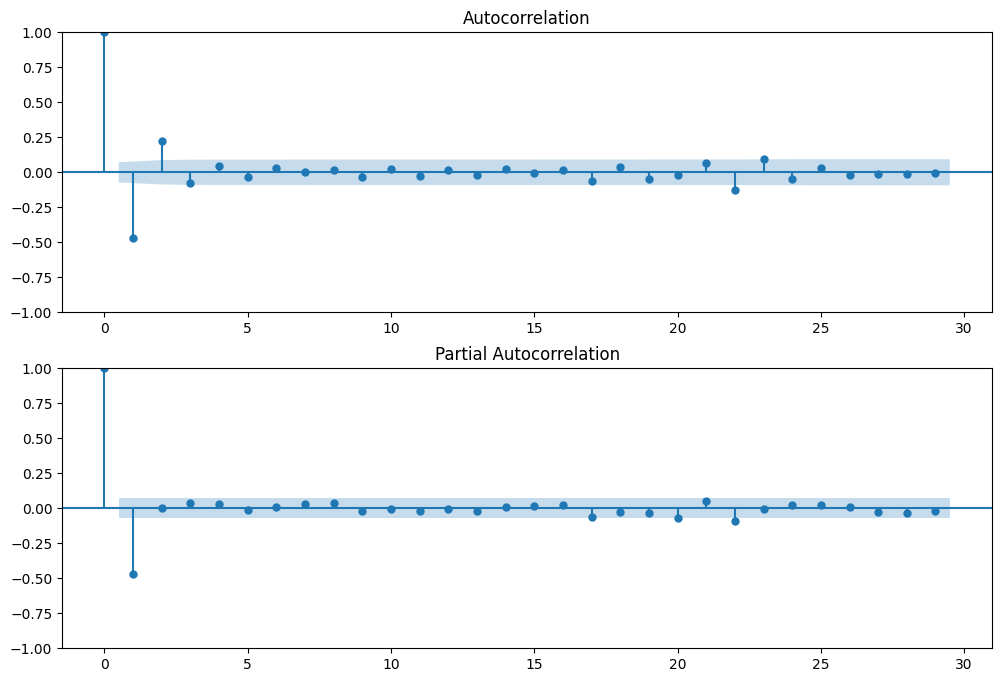

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_diff['Revenue'], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_diff['Revenue'], ax=ax2)

In [13]:
#Testing Stationarity of the adjusted data
adf_test(data_diff['Revenue'])

Test Statistic          -44.874527
p-value                   0.000000
# Lags Used               0.000000
# Observations Used     729.000000
Critical Value (1%)      -3.439352
Critical Value (5%)      -2.865513
Critical Value (10%)     -2.568886
dtype: float64


In [14]:
#Checking for nulls
print(data_diff.isna().any())
print('****************')
#Checking for duplicates
print(data_diff.duplicated().any())

Revenue    False
dtype: bool
****************
False


In [14]:
# Saving a copy of cleaned data
#data_diff2.to_csv('cleaned_time_series.csv', index = False)

We not notice above that the statistics have improved.  on this test it is way lower than our crucial values for stationarity are -3.4, -2.8, and -2.5, respectively

## __D Model Identification and Analysis__

In [15]:
# Split data into train and test sets
train_size = int(len(data) * 0.66)
train, test = data[:train_size], data[train_size:]


In [16]:

# Use auto_arima with trace on to fit the ARIMA model
arima_model = auto_arima(train['Revenue'], trace=1)

# Print the optimal p, d, and q values
print('Optimal p: {}'.format(arima_model.order[0]))
print('Optimal d: {}'.format(arima_model.order[1]))
print('Optimal q: {}'.format(arima_model.order[2]))

# Fit the ARIMA model to the training data
arima_model.fit(train['Revenue'])

# Make predictions on the test data
predictions = arima_model.predict(n_periods=30)

# Print the predictions
print(predictions)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=646.561, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=755.655, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=642.622, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=666.865, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=755.035, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=644.441, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=644.478, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=645.872, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=644.213, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.802 seconds
Optimal p: 1
Optimal d: 1
Optimal q: 0
2018-04-29    13.282790
2018-04-30    13.481976
2018-05-01    13.430657
2018-05-02    13.495014
2018-05-03    13.505955
2018-05-04    13.541562
2018-05-05    13.565779
2018-05-06    13.595256
2018-05-07    13.622304
2018-05-08    13.650473
2018-05-09    13

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# 1,0,0 ARIMA Model
model = ARIMA(train['Revenue'], order=(1,1,0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  482
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -320.106
Date:                Thu, 20 Apr 2023   AIC                            644.213
Time:                        15:10:31   BIC                            652.565
Sample:                    01-02-2017   HQIC                           647.495
                         - 04-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4579      0.040    -11.420      0.000      -0.536      -0.379
sigma2         0.2215      0.015     14.500      0.000       0.192       0.251
Ljung-Box (L1) (Q):                   0.01   Jarque-

predicted=0.073678, expected=-0.398402
predicted=0.493211, expected=0.442802
predicted=0.200065, expected=-0.650088
predicted=0.451605, expected=1.008159
predicted=-0.255253, expected=-0.324824
predicted=0.365546, expected=-0.562324
predicted=0.244546, expected=1.442980
predicted=-0.513372, expected=-1.585790
predicted=0.776759, expected=0.943729
predicted=-0.338858, expected=-0.583497
predicted=0.106102, expected=-0.212997
predicted=0.062260, expected=-0.003891
predicted=-0.167196, expected=0.640939
predicted=-0.455344, expected=-0.535783
predicted=0.334733, expected=-0.329183
predicted=-0.013814, expected=0.163790
predicted=-0.205994, expected=-0.513667
predicted=0.112459, expected=0.178902
predicted=-0.253228, expected=-0.394099
predicted=-0.128893, expected=0.628061
predicted=-0.390155, expected=-0.071771
predicted=0.037969, expected=-0.317071
predicted=0.135298, expected=-0.057014
predicted=-0.015031, expected=0.321697
predicted=-0.150852, expected=-0.589136
predicted=0.264832, ex

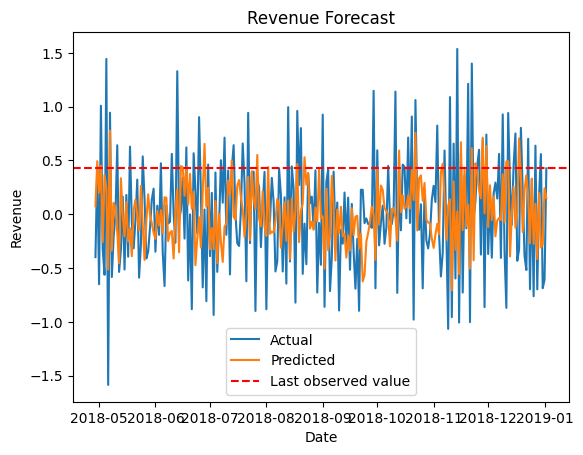

In [20]:

from sklearn.metrics import mean_squared_error
from math import sqrt
# Fit the model and make predictions
# Fit the model and make predictions
size = int(len(data_diff) * 0.66)
train, test = data_diff.iloc[:size], data_diff.iloc[size:]
history = [x for x in train['Revenue']]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Revenue'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# Calculate root mean squared error
rmse = sqrt(mean_squared_error(test['Revenue'], predictions))
print(f'RMSE: {rmse:.2f}')

 

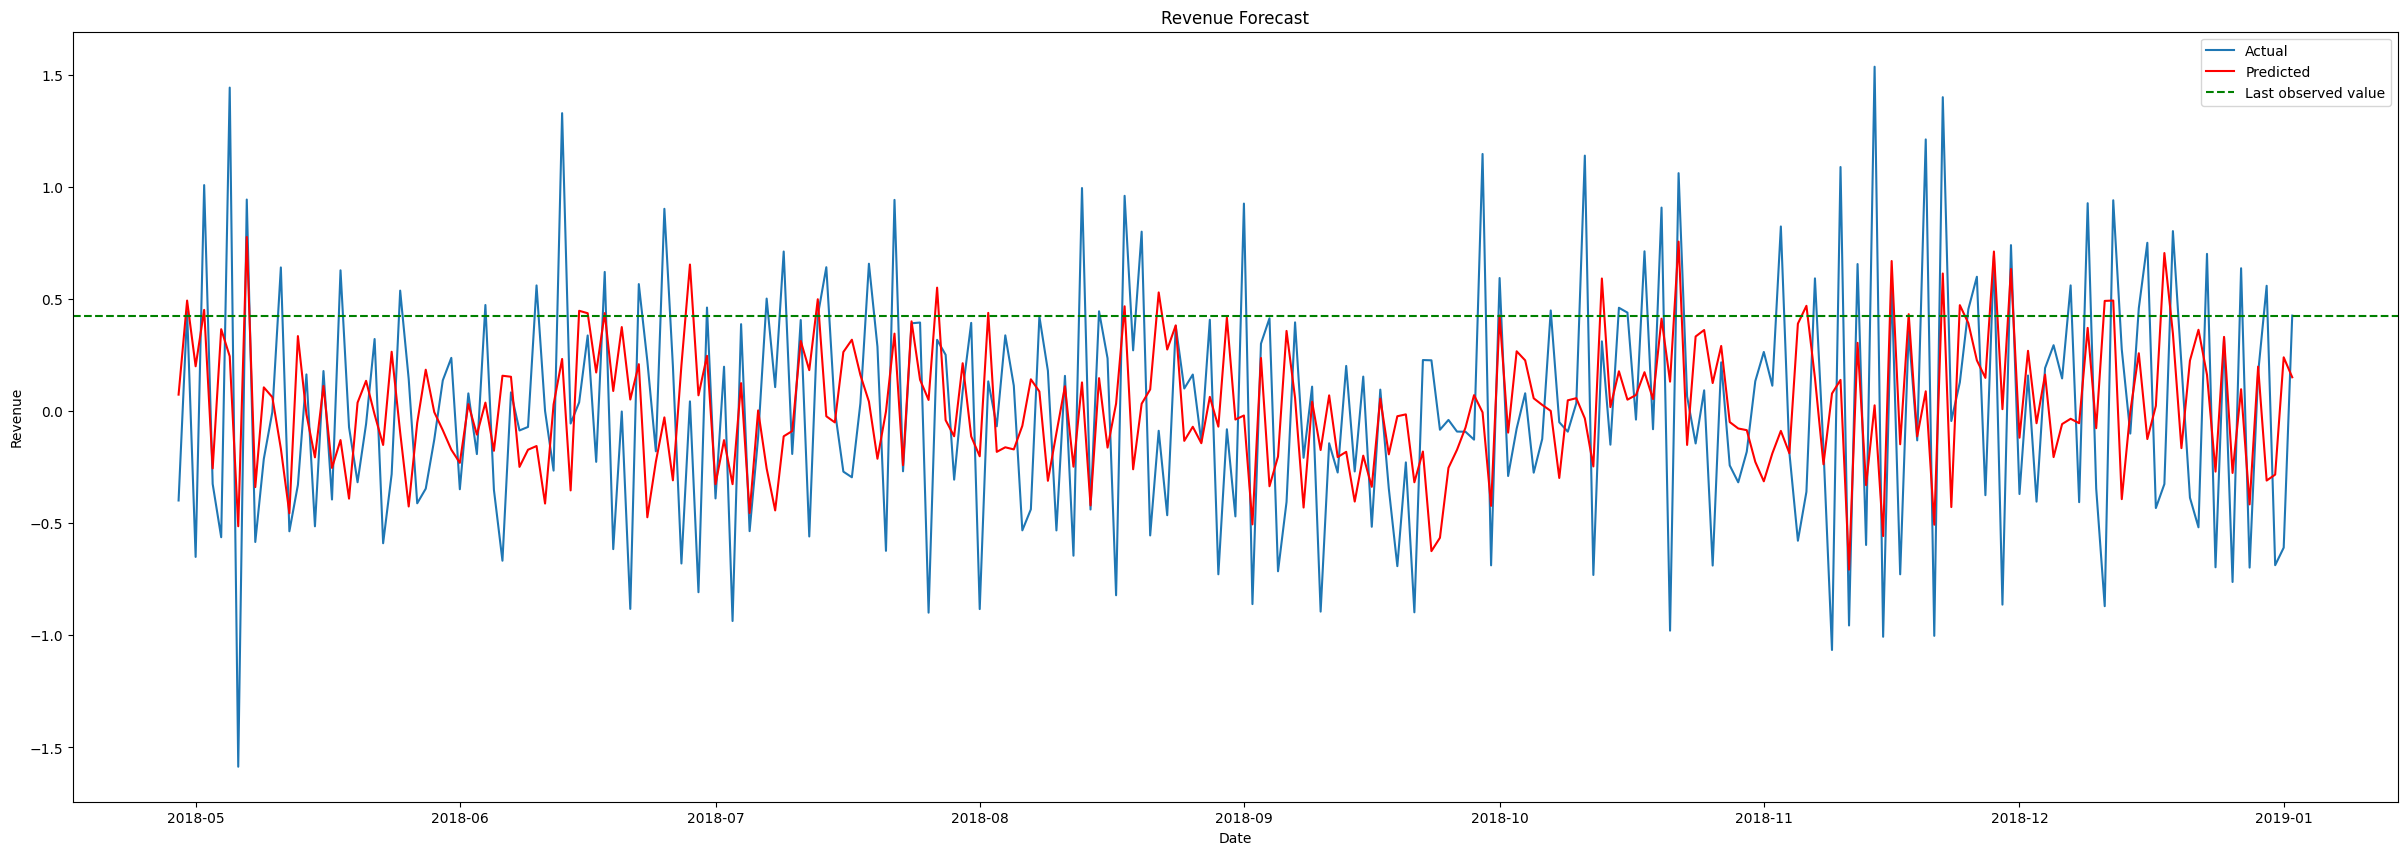

In [26]:
# Plot the results
plt.figure(figsize=(30,10))
plt.plot(test.index, test['Revenue'], label='Actual')
plt.plot(test.index, predictions, label='Predicted',color='red')
plt.axhline(y=test['Revenue'].iloc[-1], color='green', linestyle='--', label='Last observed value')
plt.title('Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

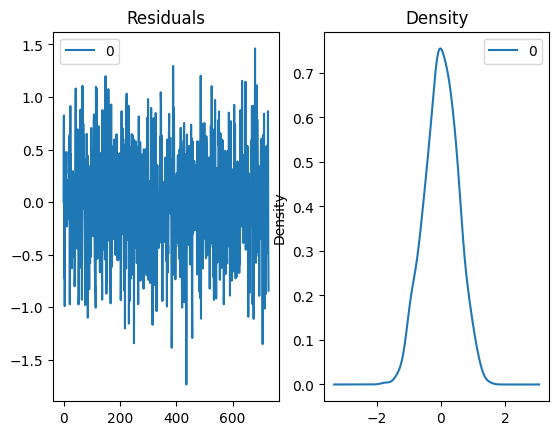

In [27]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

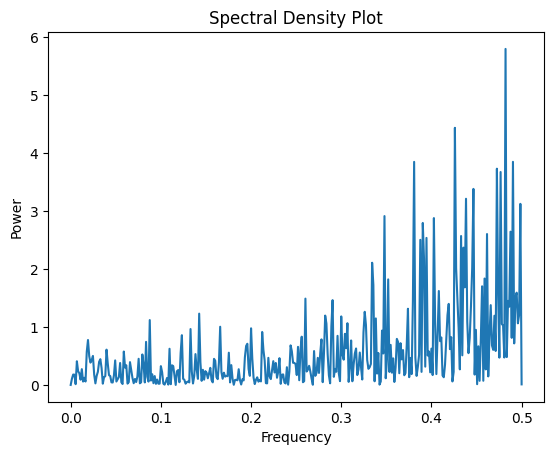

In [28]:
# Compute the spectral density for the time series data
freq, power = periodogram(data_diff['Revenue']) 
 # Create a line plot of the spectral density 
plt.plot(freq, power) 
 # Set the plot title and axis labels 
plt.title('Spectral Density Plot') 
plt.xlabel('Frequency') 
plt.ylabel('Power') 

 # Show the plot 
plt.show()